<a href="https://www.kaggle.com/sdysch/more-lagged-feature-explorations-tps-march-2022?scriptVersionId=89433875" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# Load data and basic pre-processing

In [3]:
df_train = pd.read_csv('../input/tabular-playground-series-mar-2022/train.csv')
df_test  = pd.read_csv('../input/tabular-playground-series-mar-2022/test.csv')

In [4]:
def add_date_features(df):
    df['time']  = pd.to_datetime(df['time'])
    df['day']   = df['time'].dt.dayofweek
    df['month'] = df['time'].dt.month
    df['hour']  = df['time'].dt.hour
    df['week']  = df['time'].dt.isocalendar().week
    return df

In [5]:
df_train = add_date_features(df_train)
df_test  = add_date_features(df_test)

# How does total congestion evolve on a weekly basis?

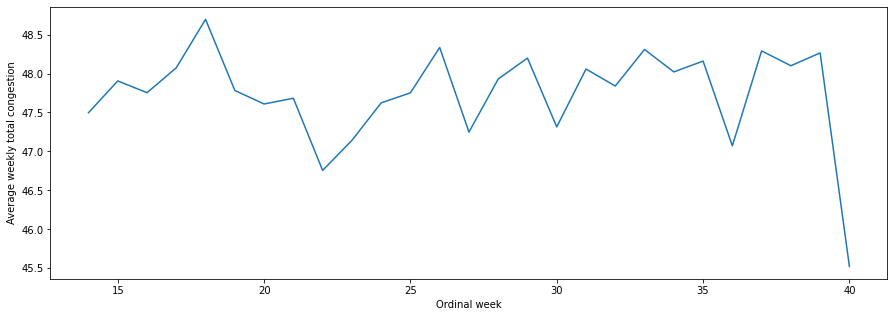

In [6]:
# Average congestion in a monthly basis
weekly_grouped = df_train.groupby('week')['congestion'].mean().reset_index()
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(weekly_grouped['week'], weekly_grouped['congestion'])

ax.set_ylabel('Average weekly total congestion')
ax.set_xlabel('Ordinal week')
plt.show()

# Weekly congestion average per road

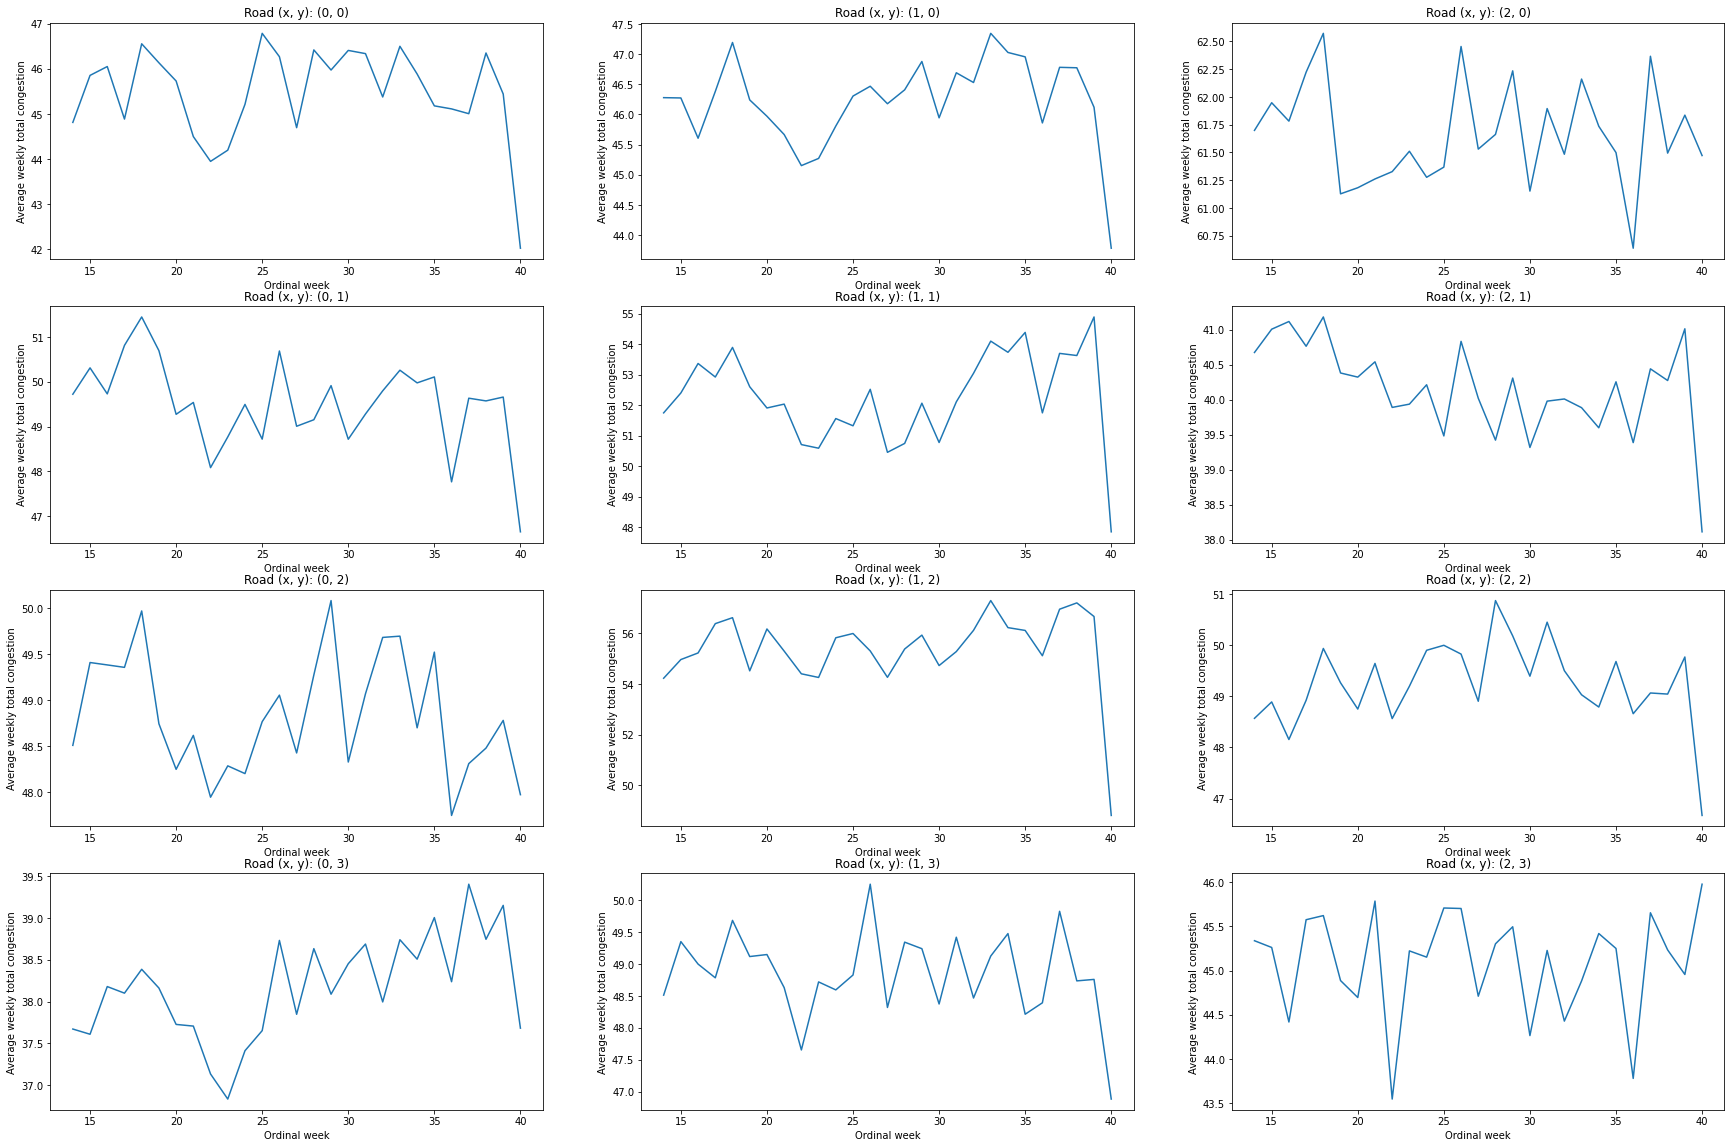

In [7]:
# Average congestion in a monthly basis
grouped = df_train.groupby(['week', 'x', 'y'])['congestion'].mean().reset_index()
fig, ax = plt.subplots(len(df_train['y'].unique()), len(df_train['x'].unique()), figsize=(30, 20))

for i, _y in enumerate(df_train['y'].unique()):
    for j, _x in enumerate(df_train['x'].unique()):
        
        view = grouped[ (grouped['x'] == _x) & (grouped['y'] == _y) ]
        
        ax[i, j].plot(view['week'], view['congestion'])
        ax[i, j].set_ylabel('Average weekly total congestion')
        ax[i, j].set_xlabel('Ordinal week')
        ax[i, j].set_title(f'Road (x, y): ({_x}, {_y})')
plt.show()

* Seems like there is an unusual drop in the average for week 40
* Particularly noticeable for road (1, 1), (1, 2),  (2, 1)

# Create week lag congestion features

In [8]:
print(df_train['x'].unique())
print(df_train['y'].unique())
print(df_train['direction'].unique())

# create lagged congestion feature, probably a better way to do this....
# unique x, y, direction pairings
x_unique         = df_train['x'].unique()
y_unique         = df_train['y'].unique()
direction_unique = df_train['direction'].unique()

print(f'Number of pairings: {len(x_unique) * len(y_unique) * len(direction_unique)}')

nlags = 20

lagged_dfs = []

# this assigns a variable congestion_week_lag_n for the congestion value on the n-1th week
for _x in x_unique:
    for _y in y_unique:
        for _direction in direction_unique:
            view = df_train[ (df_train['x'] == _x) & (df_train['y'] == _y) & (df_train['direction'] == _direction) ].copy(deep=True)
            for i in range(nlags):
                view[f'congestion_week_lag_{i+1}'] = view['congestion'].shift(i + 1)
                lagged_dfs.append(view)

[0 1 2]
[0 1 2 3]
['EB' 'NB' 'SB' 'WB' 'NE' 'SW' 'NW' 'SE']
Number of pairings: 96


In [9]:
# combine lagged DFs together
# concat them all together
df_train = pd.concat(lagged_dfs)

# drop nans
df_train.dropna(inplace=True)
#print(df_train)

# lag correlations

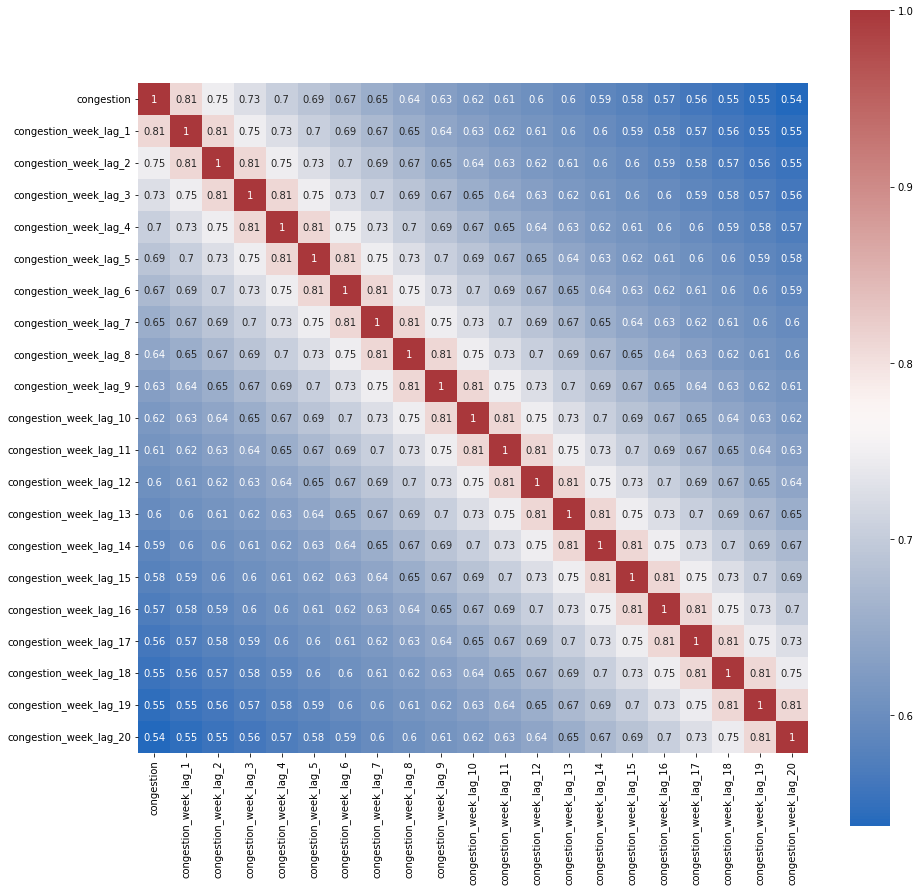

In [10]:
lags = ['congestion']
lags.extend( ['congestion_week_lag_' + str(v+1) for v in range(nlags) ] )
lag_view = df_train[lags]
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
sns.heatmap(lag_view.corr(), cmap=sns.color_palette("vlag", as_cmap=True), square=True, ax=ax, annot=True)
plt.show()

# Simple BRT model

In [11]:
# map direction with cyclical representations
# REF: https://www.kaggle.com/inversion/tps-mar-22-cyclical-features
from math import sin, cos, pi

sin_vals = {
    'NB': 0.0,
    'NE': sin(1 * pi/4),
    'EB': 1.0,
    'SE': sin(3 * pi/4),
    'SB': 0.0,
    'SW': sin(5 * pi/4),    
    'WB': -1.0,    
    'NW': sin(7 * pi/4),  
}

df_train['sin'] = df_train['direction'].map(sin_vals)

In [12]:
#print(df_train.columns)
training = df_train[
    [
        'x',
        'y',
        'day',
        'hour',
        'congestion_week_lag_1',
        'sin'
    ]
]
print(training)

        x  y  day  hour  congestion_week_lag_1       sin
1300    0  0    0     6                   57.0  1.000000
1365    0  0    0     7                   40.0  1.000000
1430    0  0    0     7                   37.0  1.000000
1495    0  0    0     7                   43.0  1.000000
1560    0  0    0     8                   57.0  1.000000
...    .. ..  ...   ...                    ...       ...
848573  2  3    0    10                   24.0 -0.707107
848638  2  3    0    10                   22.0 -0.707107
848703  2  3    0    11                   20.0 -0.707107
848768  2  3    0    11                   19.0 -0.707107
848833  2  3    0    11                   22.0 -0.707107

[16950700 rows x 6 columns]


In [13]:
# train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(training, df_train['congestion'], test_size=0.2, random_state=42)

# hyperparameter tuning

## Search space

In [14]:
# defining search space
from hyperopt import hp
#mln = [v + 1 for v in range(1, 20)]
#mln.append(None)
#print(mln)

params = {
    'n_estimators'   : hp.quniform('n_estimators', 25, 100, 25),
    'max_depth'      : hp.quniform('max_depth', 1, 20, 2),
    #'max_leaf_nodes' : hp.choice('max_leaf_nodes', mln),
}

## Objective function

In [15]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from hyperopt import STATUS_OK

def objective(params):
    global X_train, y_train, X_test, y_test
    
    print(f'Running with {params}')
    
    params['n_estimators']   = int(params['n_estimators'])
    params['max_depth']      = int(params['max_depth'])
    
    """if params['max_leaf_nodes'] is not None:
        params['max_leaf_nodes'] = int(params['max_leaf_nodes'])
"""    
    # fit model
    model = XGBRegressor(**params, random_state=42, verbosity=2, tree_method='hist')
    #model = GradientBoostingRegressor(**params, random_state=42)
    #model = RandomForestRegressor(**params, random_state=42)
    model.fit(X_train, y_train)
    
    # make predictions with fitted model
    y_pred = model.predict(X_test)
    
    print(f'Loss: {mean_absolute_error(y_pred, y_test)}')
    
    # return metrics
    return {
        'loss'     : mean_absolute_error(y_pred, y_test),
        'status'   : STATUS_OK,
        'RMSE'     : mean_squared_error(y_pred, y_test, squared=False)
        }

## Run trials

In [16]:
"""from hyperopt import fmin, tpe, Trials

trials = Trials()
best = fmin(objective,
            space = params,
            algo = tpe.suggest,
            max_evals = 50,
            trials = trials)
print(best)"""

'from hyperopt import fmin, tpe, Trials\n\ntrials = Trials()\nbest = fmin(objective,\n            space = params,\n            algo = tpe.suggest,\n            max_evals = 50,\n            trials = trials)\nprint(best)'

In [17]:
"""model = XGBRegressor(max_depth=16, n_estimators=25, random_state=42, verbosity=2, tree_method='hist')
# fit model
model = XGBRegressor(max_depth=16, n_estimators=25, random_state=42, verbosity=2, tree_method='hist')
model.fit(X_train, y_train)"""

"model = XGBRegressor(max_depth=16, n_estimators=25, random_state=42, verbosity=2, tree_method='hist')\n# fit model\nmodel = XGBRegressor(max_depth=16, n_estimators=25, random_state=42, verbosity=2, tree_method='hist')\nmodel.fit(X_train, y_train)"

In [18]:
"""# evaluate model
from sklearn.metrics import mean_absolute_error, mean_squared_error
y_pred = model.predict(X_test)

print(mean_absolute_error(y_pred, y_test))
print(mean_squared_error(y_pred, y_test, squared=False))"""

'# evaluate model\nfrom sklearn.metrics import mean_absolute_error, mean_squared_error\ny_pred = model.predict(X_test)\n\nprint(mean_absolute_error(y_pred, y_test))\nprint(mean_squared_error(y_pred, y_test, squared=False))'

# Checking with cross validation

In [19]:
"""from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

model = XGBRegressor(max_depth=16, n_estimators=25, tree_method='hist')

scores = cross_val_score(model,
                         X_train,
                         y_train,
                         cv = 5,
                         scoring = 'neg_mean_absolute_error',
                         verbose = 1)"""

"from sklearn.model_selection import cross_val_score\nfrom xgboost import XGBRegressor\n\nmodel = XGBRegressor(max_depth=16, n_estimators=25, tree_method='hist')\n\nscores = cross_val_score(model,\n                         X_train,\n                         y_train,\n                         cv = 5,\n                         scoring = 'neg_mean_absolute_error',\n                         verbose = 1)"

In [20]:
"""print(np.mean(scores))
print(np.std(scores))"""
#-4.737009782253329
#0.005871818057510222

'print(np.mean(scores))\nprint(np.std(scores))'

# Fitting model on all training data

In [21]:
from xgboost import XGBRegressor

model = XGBRegressor(max_depth=16, n_estimators=25, tree_method='hist', verbosity=2)
model.fit(training, df_train['congestion'])

[17:41:04] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[17:41:04] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[17:41:11] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 42498 extra nodes, 0 pruned nodes, max_depth=16
[17:41:11] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[17:41:14] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 51096 extra nodes, 0 pruned nodes, max_depth=16
[17:41:14] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow_quantile_histmaker.
[17:41:17] INFO: ../src/tree/updater_prune.cc:101: tree pruning end, 59664 extra nodes, 0 pruned nodes, max_depth=16
[17:41:17] INFO: ../src/gbm/gbtree.cc:177: Tree method is selected to be 'hist', which uses a single updater grow

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=16, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=25, n_jobs=4,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='hist',
             validate_parameters=1, verbosity=2)

# Preparing test data

In [22]:
# prepare testing data
df_test['congestion_week_lag_1'] = np.nan
df_test['sin'] = df_test['direction'].map(sin_vals)

In [23]:
# creating 1 week lags
#print(df_train.head())
df_lagged = df_train.copy(deep=True)
df_lagged['time'] = df_lagged['time'] + dt.timedelta(days=7)
df_lagged = df_lagged[['x', 'y', 'direction', 'time', 'congestion']]
#print(df_lagged.head())
df_lagged = df_lagged[ ['time', 'x', 'y', 'congestion', 'direction'] ]
df_lagged = df_lagged.rename(columns={'congestion' : 'congestion_week_lag_1'})

In [31]:
# really hacky way to set the lag values
testing = df_test.merge(df_lagged, on=['time', 'x', 'y', 'direction'], how='inner')
testing = testing[ testing['row_id'].isin(df_test['row_id']) ]
testing = testing.drop_duplicates()
print(testing)

       row_id                time  x  y direction  day  month  hour  week  \
0      848835 1991-09-30 12:00:00  0  0        EB    0      9    12    40   
20     848836 1991-09-30 12:00:00  0  0        NB    0      9    12    40   
40     848837 1991-09-30 12:00:00  0  0        SB    0      9    12    40   
60     848838 1991-09-30 12:00:00  0  1        EB    0      9    12    40   
80     848839 1991-09-30 12:00:00  0  1        NB    0      9    12    40   
...       ...                 ... .. ..       ...  ...    ...   ...   ...   
46700  851170 1991-09-30 23:40:00  2  3        NB    0      9    23    40   
46720  851171 1991-09-30 23:40:00  2  3        NE    0      9    23    40   
46740  851172 1991-09-30 23:40:00  2  3        SB    0      9    23    40   
46760  851173 1991-09-30 23:40:00  2  3        SW    0      9    23    40   
46780  851174 1991-09-30 23:40:00  2  3        WB    0      9    23    40   

       congestion_week_lag_1_x       sin  congestion_week_lag_1_y  
0      

In [32]:
# dropping columns not needed
testing.drop(['time', 'month', 'week', 'direction', 'congestion_week_lag_1_x'], axis=1, inplace=True)
testing = testing.rename(columns={'congestion_week_lag_1_y' : 'congestion_week_lag_1'})

In [33]:
# rearrange columns for model evaluation
testing = testing.reindex(columns=training.columns)

In [34]:
print(testing.head())
print(len(testing))

    x  y  day  hour  congestion_week_lag_1  sin
0   0  0    0    12                     55  1.0
20  0  0    0    12                     49  0.0
40  0  0    0    12                     55  0.0
60  0  1    0    12                     22  1.0
80  0  1    0    12                     59  0.0
2340


# Evaluate test data

In [35]:
pred = model.predict(testing)

In [36]:
submission = pd.read_csv('../input/tabular-playground-series-mar-2022/sample_submission.csv')
submission['congestion'] = pred
submission.to_csv('submission.csv', index=False)